In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

print("✓ Libraries loaded successfully")


# Add parent directory to path for imports
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
os.chdir(parent_dir)

from strategies.momentum import RSIMomentum, MACDMomentum, PriceMomentum
from strategies.base import backtest_strategy
from utils.indicators import calculate_returns

from utils.visualize import *
print("✓ Modules imported successfully")

✓ Libraries loaded successfully
✓ Modules imported successfully


## 1. Load Historical Data and Clean by Stocks

In [54]:
# Load all historical OHLC data
data_dir = Path("data/historical")

all_symbols = {}
for csv_file in sorted(data_dir.glob("*_ohlc.csv")):
    symbol = csv_file.stem.replace("_ohlc", "")
    try:
        df = pd.read_csv(csv_file)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        df.columns = df.columns.str.lower()
        
        # Create adj_close if not present
        if 'adj_close' not in df.columns:
            df['adj_close'] = df['close']
        
        all_symbols[symbol] = df
    except Exception as e:
        print(f"Error loading {symbol}: {e}")

print(f"✓ Loaded {len(all_symbols)} stocks from data/historical")
print(f"Symbols: {', '.join(sorted(all_symbols.keys())[:10])}...")

# Stock summary statistics
summary_stats = []
for symbol, df in all_symbols.items():
    total_return = (df['adj_close'].iloc[-1] / df['adj_close'].iloc[0]) - 1
    volatility = df['adj_close'].pct_change().std() * np.sqrt(252)  # Annualized volatility
    summary_stats.append({
        'symbol': symbol,
        'total_return': total_return,
        'volatility': volatility,
        'start_date': df['date'].iloc[0],
        'end_date': df['date'].iloc[-1],
        'num_days': len(df)
    })
summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.sort_values(by='num_days', ascending=False).reset_index(drop=True)
print("✓ Computed summary statistics for all stocks")
print(summary_df)

✓ Loaded 39 stocks from data/historical
Symbols: CEO, CIC, CII, D2D, DIG, DLG, DXG, DXS, FLC, HDC...
✓ Computed summary statistics for all stocks
   symbol  total_return  volatility start_date   end_date  num_days
0     CII     -0.610748    0.425174 2006-05-18 2026-01-15      4907
1     SJS      0.489251    0.495602 2006-07-06 2026-01-15      4868
2     TDH     -0.983279    0.441487 2006-12-14 2026-01-15      4757
3     ITA     -0.953147    0.469925 2006-11-15 2026-01-15      4682
4     VIC      1.448000    0.388694 2007-09-19 2026-01-15      4570
5     HDC     -0.712667    0.456913 2007-10-08 2026-01-15      4558
6     NTL     -0.927693    0.472603 2007-12-21 2026-01-15      4503
7     KBC     -0.701235    0.464579 2007-12-18 2026-01-15      4498
8     NBB     -0.145833    0.428309 2009-02-18 2026-01-15      4221
9     D2D     -0.071649    0.402968 2009-08-14 2026-01-15      4098
10    DIG     -0.727228    0.474060 2009-08-19 2026-01-15      4095
11    DXG     -0.611260    0.483136 20

In [ ]:
# Nếu 2 tháng gần nhất volume = 0 thì update lại end date 
# Xem như stock đã delisted
date_bounds = {}
for symbol, df in all_symbols.items():
    df_sorted = df.sort_values('date').reset_index(drop=True)
    recent_data = df_sorted.tail(40)  # Approx. 2 months of trading days
    if (recent_data['volume'] == 0).all():
        new_end_date = recent_data['date'].iloc[0] - pd.Timedelta(days=1)
        date_bounds[symbol] = (df_sorted['date'].iloc[0], new_end_date)
    else:
        date_bounds[symbol] = (df_sorted['date'].iloc[0], df_sorted['date'].iloc[-1])
    
    # Fill dữ liệu ngoài khoảng này với NaN
    mask = (df['date'] < date_bounds[symbol][0]) | (df['date'] > date_bounds[symbol][1])
    df.loc[mask, df.columns.difference(['date'])] = np.nan


In [60]:
# tạo trading days chuẩn từ VIC - align all stocks to same trading days
reference_symbol = 'CII'
if reference_symbol in all_symbols:
    # Lấy reference trading days từ VIC
    reference_df = all_symbols[reference_symbol][['date']].drop_duplicates().sort_values('date').reset_index(drop=True)
    trading_days = reference_df['date'].values
    
    # Function để align data của mỗi stock với mask
    def clean_stock_data(df_stock, symbol):
        # Remove duplicates by keeping last value for each date
        df_stock = df_stock.drop_duplicates(subset=['date'], keep='last')
        df_stock = df_stock.set_index('date').reindex(trading_days)
        
        # Tạo mask cho phạm vi [start_date, end_date]
        start_date, end_date = date_bounds.get(symbol, (trading_days[0], trading_days[-1]))
        mask = (df_stock.index >= start_date) & (df_stock.index <= end_date)
        
        # Forward fill chỉ trong mask, keep NaN bên ngoài
        df_stock[mask] = df_stock[mask]
        
        return df_stock.reset_index()
    
    # Collect statistics before and after ffill
    stats_before_ffill = []
    
    # Apply alignment cho tất cả stocks
    for symbol in all_symbols:
        df = all_symbols[symbol].copy()
        
        # Calculate stats BEFORE ffill
        df_reindexed = df.drop_duplicates(subset=['date'], keep='last')
        df_reindexed = df_reindexed.set_index('date').reindex(trading_days)
        
        start_date, end_date = date_bounds.get(symbol, (trading_days[0], trading_days[-1]))
        mask = (df_reindexed.index >= start_date) & (df_reindexed.index <= end_date)
        
        # Count missing values in 'close' column (key column)
        missing_volume = df_reindexed.loc[mask, 'volume'].isna().sum()
        total_in_range = mask.sum()
        missing_pct = (missing_volume / total_in_range * 100) if total_in_range > 0 else 0
        
        # Calculate max consecutive missing days
        is_missing = df_reindexed.loc[mask, 'volume'].isna().values
        max_consecutive = 0
        current_consecutive = 0
        for is_na in is_missing:
            if is_na:
                current_consecutive += 1
                max_consecutive = max(max_consecutive, current_consecutive)
            else:
                current_consecutive = 0
        
        stats_before_ffill.append({
            'symbol': symbol,
            'total_days_in_range': total_in_range,
            'missing_volume': missing_volume,
            'missing_pct': missing_pct,
            'max_consecutive_missing': max_consecutive
        })
        
        df_aligned = clean_stock_data(df, symbol)
        all_symbols[symbol] = df_aligned
    
    print(f"✓ Aligned all active stocks to {len(trading_days)} trading days of {reference_symbol}")
    print(f"  Date range: {trading_days[0]} to {trading_days[-1]}")
    print(f"  Forward fill applied only within each stock's data range")
    
    # Display statistics before ffill
    print("\n📊 Missing Data BEFORE Forward Fill:")
    stats_df = pd.DataFrame(stats_before_ffill).sort_values('missing_pct', ascending=False)
    print(stats_df.to_string(index=False))
    print(f"\nAverage Missing %: {stats_df['missing_pct'].mean():.2f}%")
    print(f"Max Missing %: {stats_df['missing_pct'].max():.2f}%")
    print(f"Total records with missing close: {stats_df['missing_volume'].sum()}")


✓ Aligned all active stocks to 4907 trading days of CII
  Date range: 2006-05-18T00:00:00.000000000 to 2026-01-15T00:00:00.000000000
  Forward fill applied only within each stock's data range

📊 Missing Data BEFORE Forward Fill:
symbol  total_days_in_range  missing_volume  missing_pct  max_consecutive_missing
   NTB                 3872             206     5.320248                      180
   FLC                 3514             135     3.841776                       64
   IBC                 2247              66     2.937250                       21
   ITA                 4739              97     2.046845                       92
   PPI                 3894              29     0.744735                        5
   IDC                 2031              11     0.541605                        6
   NHA                 3871              20     0.516662                        6
   DXS                 1125               3     0.266667                        3
   CIC                 1647      

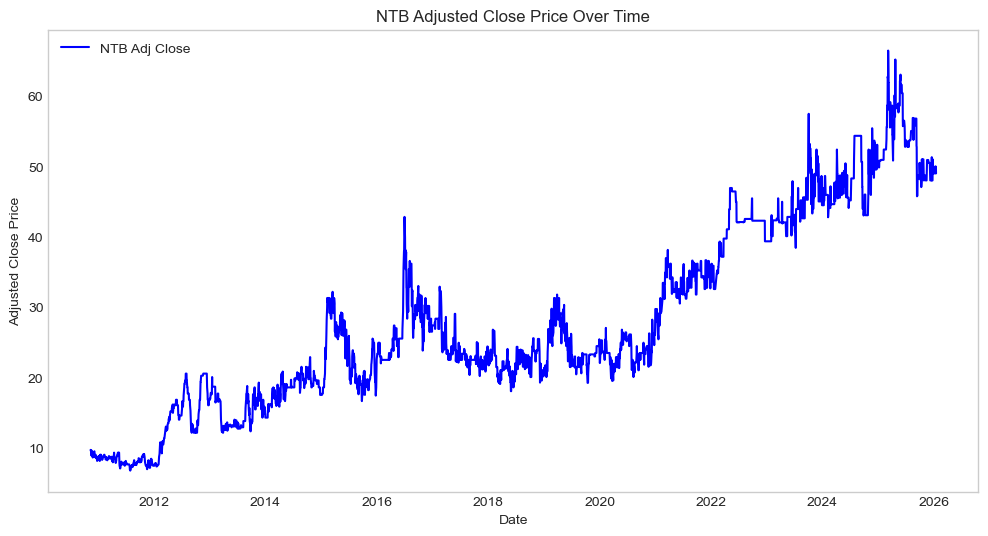

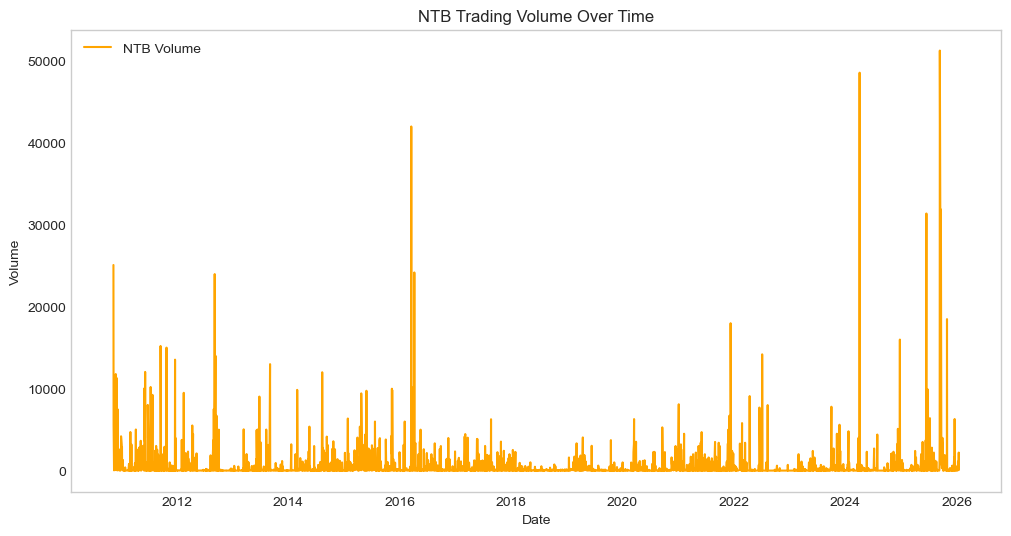

In [74]:
ntb_data = all_symbols.get('TDW')
if ntb_data is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(ntb_data['date'], ntb_data['adj_close'], label='NTB Adj Close', color='blue')
    plt.title('NTB Adjusted Close Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid()
    plt.show()

# them volume 
if ntb_data is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(ntb_data['date'], ntb_data['volume'], label='NTB Volume', color='orange')
    plt.title('NTB Trading Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Tạm bỏ qua
# Filter các stocks có max_consecutive_missing > 20 
filtered_symbols = []
for stat in stats_before_ffill:
    if stat['max_consecutive_missing'] <= 20:
        filtered_symbols.append(stat['symbol'])


In [76]:
# save to clean_v1
clean_data_dir = Path("data/clean_v1")
clean_data_dir.mkdir(parents=True, exist_ok=True)
for symbol in filtered_symbols:
    df = all_symbols[symbol]
    df.to_csv(clean_data_dir / f"{symbol}_ohlc.csv", index=False)
print(f"\n✓ Filtered stocks with max_consecutive_missing <= 20")
print(f"  Retained {len(filtered_symbols)} stocks out of {len(all_symbols)} total")


✓ Filtered stocks with max_consecutive_missing <= 20
  Retained 35 stocks out of 39 total


# EDA 

In [71]:
# === OUTLIER DETECTION & DATA QUALITY CHECK ===
print("=" * 90)
print("KIỂM TRA OUTLIER VÀ GIÁ TRỊ BẤT THƯỜNG CHO MỖI STOCK")
print("=" * 90)

def detect_outliers_by_stock(all_symbols):
    """
    Detect outliers sử dụng IQR method và thống kê
    """
    outlier_report = []
    all_extreme_returns = []
    
    for symbol, df in all_symbols.items():
        # Bỏ qua các row có NaN
        df_clean = df.dropna(subset=['open', 'high', 'low', 'close', 'volume']).copy()
        if len(df_clean) == 0:
            continue
        
        # === 1. Kiểm tra tính hợp lệ của OHLC ===
        invalid_ohlc = []
        
        # High phải >= Low
        invalid_high_low = (df_clean['high'] < df_clean['low']).sum()
        if invalid_high_low > 0:
            invalid_ohlc.append(f"High < Low: {invalid_high_low} rows")
        
        # Close phải nằm trong [Low, High]
        invalid_close = ((df_clean['close'] < df_clean['low']) | (df_clean['close'] > df_clean['high'])).sum()
        if invalid_close > 0:
            invalid_ohlc.append(f"Close outside [Low, High]: {invalid_close} rows")
        
        # Open phải nằm trong [Low, High]
        invalid_open = ((df_clean['open'] < df_clean['low']) | (df_clean['open'] > df_clean['high'])).sum()
        if invalid_open > 0:
            invalid_ohlc.append(f"Open outside [Low, High]: {invalid_open} rows")
        
        # === 2. Kiểm tra Daily Return bất thường ===
        df_clean['daily_return'] = df_clean['close'].pct_change()
        
        # IQR method
        Q1_ret = df_clean['daily_return'].quantile(0.25)
        Q3_ret = df_clean['daily_return'].quantile(0.75)
        IQR_ret = Q3_ret - Q1_ret
        lower_bound_ret = Q1_ret - 3 * IQR_ret  # 3 sigma
        upper_bound_ret = Q3_ret + 3 * IQR_ret
        
        outlier_returns = ((df_clean['daily_return'] < lower_bound_ret) | 
                          (df_clean['daily_return'] > upper_bound_ret)).sum()
        
        extreme_returns_mask = (df_clean['daily_return'] < lower_bound_ret) | (df_clean['daily_return'] > upper_bound_ret)
        extreme_returns = df_clean[extreme_returns_mask].copy()
        extreme_returns['symbol'] = symbol
        all_extreme_returns.append(extreme_returns)
        
        # === 3. Kiểm tra Volume bất thường ===
        if df_clean['volume'].sum() > 0:
            Q1_vol = df_clean['volume'].quantile(0.25)
            Q3_vol = df_clean['volume'].quantile(0.75)
            IQR_vol = Q3_vol - Q1_vol
            lower_bound_vol = Q1_vol - 3 * IQR_vol
            upper_bound_vol = Q3_vol + 3 * IQR_vol
            
            # Loại bỏ volume = 0
            df_vol = df_clean[df_clean['volume'] > 0]
            outlier_volumes = ((df_vol['volume'] < lower_bound_vol) | 
                              (df_vol['volume'] > upper_bound_vol)).sum()
        else:
            outlier_volumes = 0
        
        # === 4. Kiểm tra Price bất thường (Z-score) ===
        price_zscore = np.abs((df_clean['close'] - df_clean['close'].mean()) / df_clean['close'].std())
        extreme_prices = (price_zscore > 3).sum()  # 3 sigma
        
        # === 5. Tóm tắt ===
        outlier_report.append({
            'symbol': symbol,
            'total_records': len(df_clean),
            'invalid_ohlc_count': len(invalid_ohlc),
            'invalid_ohlc_issues': '; '.join(invalid_ohlc) if invalid_ohlc else 'None',
            'outlier_returns': outlier_returns,
            'outlier_return_pct': (outlier_returns / len(df_clean) * 100) if len(df_clean) > 0 else 0,
            'max_daily_return': df_clean['daily_return'].max(),
            'min_daily_return': df_clean['daily_return'].min(),
            'outlier_volumes': outlier_volumes,
            'extreme_prices': extreme_prices
        })
    
    extreme_returns_df = pd.concat(all_extreme_returns, ignore_index=True) if all_extreme_returns else pd.DataFrame()
    return pd.DataFrame(outlier_report), extreme_returns_df

# Run outlier detection - chỉ trên các stocks đã được filter
filtered_data = {sym: all_symbols[sym] for sym in filtered_symbols if sym in all_symbols}
print(f"Running outlier detection trên {len(filtered_data)} filtered symbols...")
print(f"Excluded {len(all_symbols) - len(filtered_data)} stocks có max_consecutive_missing > 20\n")
outlier_df, extreme_returns_sample = detect_outliers_by_stock(filtered_data)

# === DISPLAY RESULTS ===
print("\n1️⃣ TÓNG HỢP OUTLIER CHO TẤT CẢ STOCKS:")
print("─" * 90)
display_cols = ['symbol', 'total_records', 'invalid_ohlc_count', 'outlier_returns', 
                'outlier_return_pct', 'outlier_volumes', 'extreme_prices']
print(outlier_df[display_cols].sort_values('outlier_return_pct', ascending=False).to_string(index=False))

print("\n\n2️⃣ THỐNG KÊ OUTLIER:")
print("─" * 90)
print(f"Stocks có OHLC không hợp lệ: {(outlier_df['invalid_ohlc_count'] > 0).sum()}")
if (outlier_df['invalid_ohlc_count'] > 0).any():
    print("  Detail:")
    for _, row in outlier_df[outlier_df['invalid_ohlc_count'] > 0].iterrows():
        print(f"  - {row['symbol']}: {row['invalid_ohlc_issues']}")

print(f"\nStocks có return outlier > 3%: {(outlier_df['outlier_return_pct'] > 3).sum()}")
print(f"Average outlier return %: {outlier_df['outlier_return_pct'].mean():.2f}%")

print(f"\nStocks có volume outlier: {(outlier_df['outlier_volumes'] > 0).sum()}")
print(f"Stocks có price extreme (3 sigma): {(outlier_df['extreme_prices'] > 0).sum()}")

print("\n\n3️⃣ EXTREME DAILY RETURNS (> 3 sigma):")
print("─" * 90)
if isinstance(extreme_returns_sample, pd.DataFrame) and len(extreme_returns_sample) > 0:
    display_cols = ['date', 'symbol', 'close', 'daily_return']
    available_cols = [col for col in display_cols if col in extreme_returns_sample.columns]
    print(extreme_returns_sample[available_cols].head(20).to_string(index=False))
    print(f"\nTotal extreme returns detected: {len(extreme_returns_sample)}")
else:
    print("No extreme returns found")

print("\n\n4️⃣ VẬN ĐỀ CẦN XỰWLÝ:")
print("─" * 90)
issues = {
    'invalid_ohlc': outlier_df[outlier_df['invalid_ohlc_count'] > 0]['symbol'].tolist(),
    'high_outliers': outlier_df[outlier_df['outlier_return_pct'] > 5]['symbol'].tolist(),
    'volume_outliers': outlier_df[outlier_df['outlier_volumes'] > 10]['symbol'].tolist(),
}

for issue_type, stocks in issues.items():
    if stocks:
        print(f"\n🔴 {issue_type.upper()}: {stocks}")
    else:
        print(f"\n✅ {issue_type.upper()}: No issues found")

print("\n" + "=" * 90)


KIỂM TRA OUTLIER VÀ GIÁ TRỊ BẤT THƯỜNG CHO MỖI STOCK
Running outlier detection trên 35 filtered symbols...
Excluded 4 stocks có max_consecutive_missing > 20


1️⃣ TÓNG HỢP OUTLIER CHO TẤT CẢ STOCKS:
──────────────────────────────────────────────────────────────────────────────────────────
symbol  total_records  invalid_ohlc_count  outlier_returns  outlier_return_pct  outlier_volumes  extreme_prices
   TDW           3785                   1             1779           47.001321              524               0
   PPI           3865                   1              451           11.668823              186              96
   PDR           3858                   1              185            4.795231              239             182
   NVL           2256                   2              103            4.565603              104               0
   VHM           1917                   1               64            3.338550               33               1
   TTA           1329                 